# CNN Model to classify a disease based on the chest x-ray

In [84]:
#importing the necessary libraries
import numpy as np
from numpy import asarray

import pandas as pd
import os
import matplotlib.pyplot as plt

from itertools import chain
from PIL import Image

%matplotlib inline

In [53]:
plt.rcParams["font.size"] = 30
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.titlesize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 10

In [5]:
data_entry_file_name = "Data_Entry_2017.csv"
#bbox_list_file_name = "BBox_List_2017.csv"
data_entry_df  = pd.read_csv(data_entry_file_name)
#bbox_df = pd.read_csv(bbox_list_file_name)

In [6]:
data_entry_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [78]:
#let's rename the columns in our dataframe so that it's more compact 
#data_entry_df.rename(columns={"OriginalImage[Width": "ImageWidth", "Height]": "ImageHeight", "OriginalImagePixelSpacing[x": "ImgPixelSpacingX", "y]": "ImgPixelSpacingY"})

In [80]:
data_entry_set = set(data_entry_df['Finding Labels'])
data_entry_set

{'Atelectasis',
 'Atelectasis|Cardiomegaly',
 'Atelectasis|Cardiomegaly|Consolidation',
 'Atelectasis|Cardiomegaly|Consolidation|Edema',
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration',
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass',
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule',
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Mass',
 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Pleural_Thickening',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule|Pleural_Thickening',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Pneumonia',
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|M

It seems that there are a lot of multi-labeled data in our diagnosis. Later we will have to map it out in its separate label so that our model can use it.

In [9]:
data_entry_df['Finding Labels'].value_counts()

No Finding                                                     60361
Infiltration                                                    9547
Atelectasis                                                     4215
Effusion                                                        3955
Nodule                                                          2705
                                                               ...  
Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule                  1
Consolidation|Infiltration|Nodule|Pneumonia                        1
Consolidation|Mass|Nodule|Pneumonia                                1
Consolidation|Emphysema|Infiltration|Nodule                        1
Atelectasis|Effusion|Infiltration|Pneumothorax|Cardiomegaly        1
Name: Finding Labels, Length: 836, dtype: int64

In [40]:
data_entry_df[data_entry_df['Patient Age']== 58]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
573,00000140_000.png,No Finding,0,140,25,F,PA,2048,2500,0.168000,0.168000
979,00000245_000.png,No Finding,0,245,25,M,AP,2500,2048,0.171000,0.171000
1239,00000317_002.png,No Finding,2,317,25,F,PA,2048,2500,0.168000,0.168000
1334,00000344_004.png,Nodule,4,344,25,M,PA,2992,2991,0.143000,0.143000
1816,00000468_051.png,No Finding,51,468,25,M,PA,2048,2500,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
111678,00030589_000.png,No Finding,0,30589,25,M,PA,2021,2021,0.194311,0.194311
111778,00030627_000.png,No Finding,0,30627,25,F,PA,2021,2021,0.194311,0.194311
111945,00030685_001.png,No Finding,1,30685,25,M,AP,3056,2544,0.139000,0.139000
112068,00030769_000.png,No Finding,0,30769,25,F,PA,1637,1788,0.194311,0.194311


Let's see if we can read some of the x-ray images

In [51]:
home_path = os.path.expanduser('~')
git_dir = os.path.join(home_path, "Documents\\WFT\\DataScience\\Git")
nih_dir = os.path.join(git_dir, "NIH-CHEST-XRAY")
data_dir = os.path.join(nih_dir, "data")
train_val_imagelist_file = os.path.join(data_dir, "train_val_list.txt")
images_001_dir = os.path.join(data_dir, "images_001\\images")
images_001_list = []

train_val_file = open(train_val_imagelist_file , 'r')
for line in train_val_file:
    line = line.rstrip("\n")
    file_loc = os.path.join(images_001_dir, line)
    images_001_list.append(file_loc)
train_val_file.close()

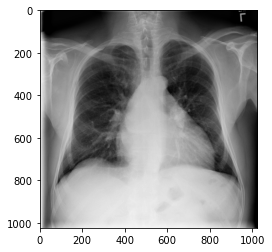

In [52]:
image_index_1 = 0

image_orig_1 = Image.open(images_001_list[image_index_1])
plt.imshow(image_orig_1, cmap='gray')

In [54]:
# convert image to numpy array
data = asarray(image_orig_1)
#print(type(data))
# summarize shape
#print(data.shape)
print(data)

# create Pillow image
#image2 = Image.fromarray(data)
#print(type(image2))

# summarize image details
#print(image2.mode)
#print(image2.size)

[[202 199 195 ...   5   2   0]
 [199 196 195 ...   5   2   0]
 [196 194 193 ...   5   2   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 254 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


In [81]:
X = data_entry_df[0:20]
X

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143


In [82]:
patient_set = set(data_entry_df['Patient ID'])
len(patient_set)

30805

In [89]:
data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*data_entry_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
len(all_labels)
for current_label in all_labels:
    #if we find a non-empty label, map it to a separate column with a value '1' and leave '0' for the ones not found
    #so in the end we have an encoded array
    if(len(current_label)>1):
        data_entry_df[current_label] = data_entry_df['Finding Labels'].map(lambda found: 1.0 if current_label in found else 0)
data_entry_df.sample(25)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
53561,00013531_005.png,,5,13531,52,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62896,00015556_004.png,Atelectasis|Emphysema,4,15556,56,M,AP,2500,2048,0.168000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8119,00002129_000.png,Infiltration,0,2129,68,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7532,00001979_002.png,Infiltration,2,1979,59,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
87990,00021770_006.png,Consolidation|Infiltration,6,21770,8,F,PA,1349,1430,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67057,00016571_001.png,,1,16571,75,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30870,00008042_006.png,,6,8042,48,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73663,00018114_000.png,,0,18114,34,M,PA,2858,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87910,00021750_014.png,Atelectasis|Pleural_Thickening,14,21750,68,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45102,00011579_023.png,Atelectasis|Effusion,23,11579,57,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
diseases_df = data_entry_df[['Image Index','Effusion','Atelectasis','Cardiomegaly','Consolidation','Edema', 
                         'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration','Mass', 'Nodule',
                          'Pleural_Thickening', 'Pneumonia','Pneumothorax'
                         ]]
diseases_df

,Image Index,Effusion,Atelectasis,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


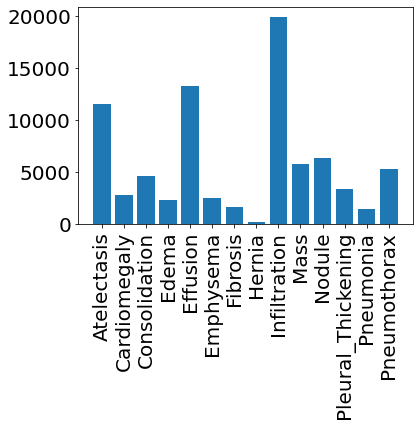

In [139]:
disease_counts = []

for l in all_labels:
    tempcount = (diseases_df[l] != 0).sum()
    disease_counts.append(tempcount)
    
diseases_counts_combined_df = []
for l,c in zip(all_labels,disease_counts):
    temp =(l,c)
    diseases_counts_combined_df.append(temp)
diseases_counts_combined_df

y_pos = np.arange(len(all_labels))
 
# Create bars
plt.bar(y_pos, disease_counts)
 
# Create names on the x-axis
plt.xticks(y_pos, all_labels, rotation = 90)
 
# Show graphic
plt.show()


In [61]:
given_labels = np.array(['Atelectasis', 'Cardiomegaly', 'Consolidation','Edema', 
                         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 
                         'Pneumothorax'])

d1 = dict((given_labels[i], i) for i in range(len(given_labels)))
#d1
d2 = dict(zip(data_entry_df['Image Index'], data_entry_df['Finding Labels']))
#d2
diseases = {k: v.split("|") for k, v in d2.items()}
#len(diseases.keys())




112120

In [65]:
diseases_df = pd.DataFrame.from_dict(diseases, orient='index')
diseases_df

,0,1,2,3,4,5,6,7,8
00000001_000.png,Cardiomegaly,None,None,None,None,None,None,None,None
00000001_001.png,Cardiomegaly,Emphysema,None,None,None,None,None,None,None
00000001_002.png,Cardiomegaly,Effusion,None,None,None,None,None,None,None
00000002_000.png,No Finding,None,None,None,None,None,None,None,None
00000003_000.png,Hernia,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
00030801_001.png,Mass,Pneumonia,None,None,None,None,None,None,None
00030802_000.png,No Finding,None,None,None,None,None,None,None,None
00030803_000.png,No Finding,None,None,None,None,None,None,None,None
00030804_000.png,No Finding,None,None,None,None,None,None,None,None
